# Stat 143 Short Project 1 

Authors: Seth Billiau and Sarah Lucioni 

Code was written together during a Zoom call. Each person contributed equally to the project. 

Seth used 2005-2006 season data, and Sarah used 2014-2015 season data. You can change the path/season variables to view different projects. 


In [186]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import block_diag
import scipy.stats as stats
import statsmodels.api as sm
from tqdm import tqdm
import math
import pickle
plt.style.use('ggplot')

In [187]:
# set DATADIR
DATADIR = "data/"

# Normal Model

In [188]:
def load_nfl_data(season=2017):
    """Loads in NFL match result data from CSV file located in your DATADIR
    
    :param season: The season we want to do analysis on
    :return: a pandas dataframe containing the scores of every NFL game in the
        given season
    """
    NFL = pd.read_csv(DATADIR+'NFL_Scores.csv')

    # select the relevant season
    NFL_season = NFL[NFL.schedule_season==season]
    # remove play-off games
    NFL_season = NFL_season.iloc[:-11]
    return NFL_season

def get_X(teams,NFL_season):
    """Creates the X matrix for the normal model calculation

    :param teams: numpy array of all unique teams in the match result dataset
    :param NFL_season: pandas dataframe containing NFL match result data
    :return: A numpy array where each row is a unique game of the dataset, and each column represents a team
    """
    # calculate number of teams
    nteams = teams.size
    # calculate number of games
    ngames = NFL_season.shape[0]
    # assign each game a unique id
    game_id = np.arange(ngames)
    # initalize X matrix
    X = np.zeros((ngames,nteams))
    # populate home teams
    home_team_idx = np.searchsorted(teams,NFL_season.team_home)
    X[game_id,home_team_idx] = 1
    # populate away teams
    away_team_idx = np.searchsorted(teams,NFL_season.team_away)
    X[game_id,away_team_idx] = -1    
    return X

def get_W(nteams):
    """Creates the W matrix for the normal model calculation, with the constraint that team strengths must sum to 0

    :param nteams: An integer representing the number of teams in our dataset for generating the W matrix
    :return: W matrix for estimating team strength
    """
    # set up an nteams x nteams identify matrix
    W = np.eye(nteams)
    # set all elements in the last row = -1
    W[-1,:] = -1
    # remove the last column
    W = W[:,:-1]
    return W

def make_team_strength_plot(season,team_params):
    teamnames = [t[0] for t in team_params]
    theta_ = [t[1] for t in team_params]
    # plot outcomes
    fig, ax = plt.subplots(figsize=(6,8))
    ax.barh(teamnames,theta_,facecolor='red',alpha=0.3,height=0.5)
    fig.suptitle('         Team strength estimates, NFL %d-%d' % (season,season+1),y=0.92)
    ax.set_xlabel('Team strength')
    ax.xaxis.grid(True)
    fig.subplots_adjust(left=0.3)


3.78125 14.639916271533114


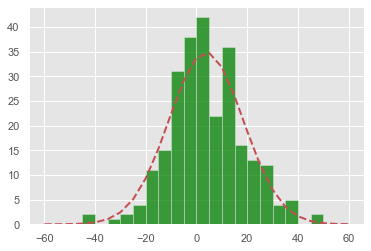

In [179]:
# Load Season for parameter training
season = 2005 # Seth's season
# season = 2014 # Sarah's season
NFL_season = load_nfl_data(season=season) 

# Fit a normal distribution to score differentials
score_diff = NFL_season.score_home-NFL_season.score_away
(mu, sigma) = stats.norm.fit(score_diff)

# the histogram of the data
fig,ax = plt.subplots()
n, bins, patches = ax.hist(score_diff, np.arange(-60,65,5),facecolor='green', alpha=0.75)

# add a 'best fit' line
y = stats.norm.pdf( bins, mu, sigma)
print(mu,sigma)
ax.plot(bins, y*score_diff.size*5, 'r--', linewidth=2)


In [ ]:
# find all the team names (and sort)
teams = np.unique( NFL_season[['team_home','team_away']] )
# calculate number of teams
nteams = teams.size
# calculate number of games
ngames = NFL_season.shape[0]
# calculate design matrix
X = get_X(teams,NFL_season)
# get observed score differentials
y = NFL_season.score_home - NFL_season.score_away
# construct linear constraint matrix
W = get_W(nteams)
# Add extra row and column for home advantage
Wh = block_diag(W,[1])

Xh = np.c_[X,np.ones(ngames)]
Xhs = np.matmul(Xh,Wh)

# solution! (the @ symbol is another way of doing matrix multiplication in python)
gamma = np.linalg.inv( Xhs.T @ Xhs  ) @ Xhs.T @ y 

Indianapolis Colts,10.785,3.152
Denver Broncos,10.735,3.152
San Diego Chargers,9.884,3.152
Seattle Seahawks,9.047,3.152
Pittsburgh Steelers,7.832,3.152
New York Giants,6.999,3.154
Kansas City Chiefs,6.950,3.152
Washington Redskins,5.884,3.152
Carolina Panthers,5.177,3.152
Jacksonville Jaguars,4.747,3.152
Cincinnati Bengals,3.836,3.152
New England Patriots,3.201,3.152
Dallas Cowboys,3.049,3.152
Chicago Bears,1.460,3.152
Miami Dolphins,-0.710,3.152
Tampa Bay Buccaneers,-0.897,3.152
Atlanta Falcons,-1.121,3.152
Baltimore Ravens,-1.817,3.152
Philadelphia Eagles,-2.413,3.152
Oakland Raiders,-2.860,3.152
Minnesota Vikings,-3.477,3.152
Green Bay Packers,-3.653,3.152
Cleveland Browns,-4.204,3.152
Arizona Cardinals,-5.047,3.152
St. Louis Rams,-5.192,3.152
Buffalo Bills,-5.789,3.152
New York Jets,-6.337,3.152
Detroit Lions,-6.633,3.152
Tennessee Titans,-7.584,3.152
Houston Texans,-10.044,3.152
New Orleans Saints,-10.595,3.154
San Francisco 49ers,-11.212,3.152
Beta,3.644, 0.773
Residual standard 

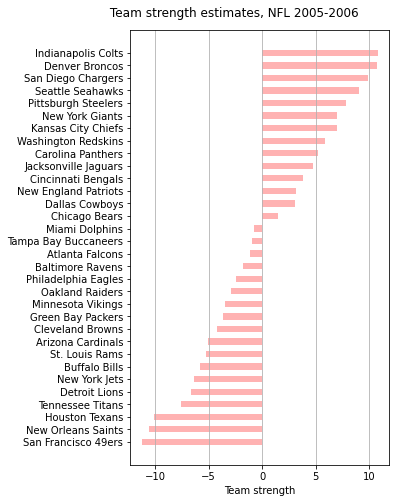

In [16]:
# the n-1 strength parameters 
theta_n1 = gamma[:-1]
#  home advantage parameter
beta = gamma[-1]
# calculate the nth team strength
theta_n = np.append( theta_n1,-theta_n1.sum() )
yhat = Xh @ np.append( theta_n,beta )

# variance of residuals
svar = np.dot(y-yhat,y-yhat) / (ngames-nteams)
# covariance matrix of coefficients
theta_covar = svar * Wh @ np.linalg.inv( Xhs.T @ Xhs ) @ Wh.T 
# standard errors of  coefficients
theta_sigma = np.sqrt( np.diagonal(theta_covar) )

# now list & plot soltuions

team_params = []
for team,theta,sigma in zip(teams,theta_n,theta_sigma):
    team_params.append((team,theta.round(3),sigma.round(3)))

team_params = sorted(team_params,key=lambda x: x[1], reverse=False)
for tp in team_params[::-1]:
    print("%s,%1.3f,%1.3f" % tuple(tp))
print("Beta,%1.3f, %1.3f" % (beta,theta_sigma[-1]))
print("Residual standard deviation,%1.3f," % (np.sqrt(svar)))

# MAKE_PLOT
make_team_strength_plot(season,team_params)

In [40]:
# define constants for Divisions
teamsToDivisions = {"Seattle Seahawks": "NFC West", 
                    "Los Angeles Rams": "NFC West", 
                    "St. Louis Rams": "NFC West", 
                    "Arizona Cardinals": "NFC West", 
                    "San Francisco 49ers": "NFC West", 
                    "New Orleans Saints": "NFC South", 
                    "Tampa Bay Buccaneers": "NFC South", 
                    "Carolina Panthers": "NFC South", 
                    "Atlanta Falcons": "NFC South", 
                    "Washington Redskins": "NFC East",
                    "New York Giants": "NFC East", 
                    "Dallas Cowboys": "NFC East", 
                    "Philadelphia Eagles": "NFC East", 
                    "Green Bay Packers": "NFC North", 
                    "Chicago Bears": "NFC North", 
                    "Minnesota Vikings": "NFC North", 
                    "Detroit Lions": "NFC North", 
                    "Tennessee Titans": "AFC South", 
                    "Indianapolis Colts": "AFC South", 
                    "Houston Texans": "AFC South", 
                    "Jacksonville Jaguars": "AFC South", 
                    "Buffalo Bills": "AFC East", 
                    "Miami Dolphins": "AFC East", 
                    "New England Patriots": "AFC East", 
                    "New York Jets": "AFC East", 
                    "Pittsburgh Steelers": "AFC North",
                    "Baltimore Ravens": "AFC North", 
                    "Cleveland Browns": "AFC North", 
                    "Cincinnati Bengals": "AFC North", 
                    "Kansas City Chiefs": "AFC West", 
                    "Oakland Raiders": "AFC West", 
                    "San Diego Chargers": "AFC West", 
                    "Denver Broncos": "AFC West"
            }
Divisions = np.unique( list(teamsToDivisions.values()) )


In [41]:

def run_sims(team_param_dict,nsims=10000,draw_strengths=True, season = 2015):    
    # load data from appropriate season
    NFLseason = load_nfl_data(season)

    # get fixture schedule    
    fixtures = NFLseason[['team_home','team_away']]
    fixtures = fixtures.reset_index(drop=True)
    teams = np.unique( fixtures[['team_home','team_away']] )
    
    # store the NFL tables for each simulation in a list    
    tables = []
    # now run the simulations
    for i in tqdm(np.arange(nsims)):
        if draw_strengths:
            # treat the team strength of each team as a random varaible, drawing from a distribution determined by their expected value and sample error
            sim_param_dict = draw_from_strength_params(teams,team_param_dict)
        else:
            # don't draw team strenghts, just keep them fixed at their expected value
            sim_param_dict = team_param_dict
        # simulate the season once
        completed_fixtures = sim_season(fixtures,sim_param_dict)
        # append the league table for simulated season to the list
        tables.append( generate_table(completed_fixtures) )
        
    # Analyze the results
    team_summary = analyse_sim_results(tables, teams)
    return tables, team_summary


def draw_from_strength_params(teams,team_param_dict):
    '''
    Draw a new set of team strength, home advantage and intercept parameters from the standard errors on the theta values
    '''
    sim_param_dict = team_param_dict.copy()
    sigma_team = team_param_dict["sigma"]
    for team in teams:
        sim_param_dict[team] = stats.norm.rvs(0,sigma_team,1) + team_param_dict[team]
    
    sigma_beta = team_param_dict['beta'][1]
    sim_param_dict['beta'] = stats.norm.rvs(0,sigma_beta,1) + team_param_dict['beta'][0]
    return sim_param_dict

def sim_match(home,away,team_param_dict):    
    # calculate the mean score differential (using team strengths & home advantage)
    mu_diff = team_param_dict[home] - team_param_dict[away] + team_param_dict['beta'][0]
    home_idx = np.where(teams == home)[0][0]
    away_idx = np.where(teams == away)[0][0]
    # calculate and draw a score differential normal random variable
    cov_between = theta_covar[home_idx, away_idx]
    score_diff_var = team_param_dict["sigma"]**2 + team_param_dict["sigma"]**2 - 2 * cov_between

    score_diff = stats.norm.rvs(mu_diff, np.sqrt(score_diff_var), 1)
    return np.round(score_diff,3), np.round(-score_diff, 3)

def sim_season(fixtures,team_param_dict):
    '''
    simulate a single season using the fixtures given in the 'fixtures' dataframe
    '''
    # make a copy of the fixture list. we'll populate this with the results
    completed_fixtures = fixtures.copy()
    nmatches = fixtures.shape[0]
    homeScoreDiffs = np.zeros(nmatches)
    awayScoreDiffs = np.zeros(nmatches)
    # go through fixture schedule and simulated each match
    for i,row in completed_fixtures.iterrows():
        homeScoreDiffs[i],awayScoreDiffs[i] = sim_match(row['team_home'],row['team_away'],team_param_dict)
    # fill in scores in fixture schedule
    completed_fixtures['homeScoreDiffs'] = homeScoreDiffs
    completed_fixtures['awayScoreDiffs'] = awayScoreDiffs
    return completed_fixtures
    
def generate_table(results):
    ''' 
    produce a league table from a simulation of a single team
    '''
    teams = np.unique( results[['team_home','team_away']] )
    table = []
    # loop through each team
    for team in teams:
        # get all the team's home & away games
        homegames = results[results['team_home']==team]
        awaygames = results[results['team_away']==team]
        
        # calculate the team's home wins/losses
        homeWins = sum(homegames.homeScoreDiffs > 0)
        homeLosses = sum(homegames.homeScoreDiffs < 0)
        # calculate the team's away wins/losses
        awayWins = sum(awaygames.awayScoreDiffs > 0)
        awayLosses = sum(awaygames.awayScoreDiffs < 0)
        # calculate total wins/losses
        totalWins = homeWins + awayWins
        totalLosses = homeLosses + awayLosses
        
        # append results to the table list
        table.append((team,totalWins,totalLosses,homeWins,homeLosses,awayWins,awayLosses))
    # sort the table by points, then homeWins, then awayWins
    
    table = add_ranks(table)
    
    # Sort by team
    table = sorted(table, key = lambda x: (x[0]), reverse=False)
    return table
    
def analyse_sim_results(tables,teams,printout=False, asDataframe=True):
    '''
    analyse the simulation results over all simulations
    '''
    team_summary = []
    nsims = len(tables)
    for teamidx, team in enumerate(teams):
        dfTeam = pd.DataFrame(np.array(tables)[:,teamidx,:],  columns = ["team",
                                                                       "totalWins",
                                                                       "totalLosses",
                                                                       "homeWins",
                                                                       "homeLosses",
                                                                       "awayWins",
                                                                       "awayLosses",
                                                                       "leagueRank",
                                                                       "division", 
                                                                       "divisionRank"])
        
        

        # proportion of sims in which team finished first in the league table
        bestteam = np.sum(dfTeam["leagueRank"]==1)/nsims*100
        # proportion of sims in which team finished in the top 4 
        wonDivision = np.sum(dfTeam["divisionRank"]==1)/nsims*100

        # average Total Wins
        totalWins_mean = np.mean(dfTeam["totalWins"])
        # 2.5th percentile of Total Wins
        totalWins_low = np.percentile(dfTeam["totalWins"],2.5, interpolation='nearest')
        # 97.5th percentile of Total Wins
        totalWins_high = np.percentile(dfTeam["totalWins"],97.5, interpolation='nearest')
        
        # average league finish
        league_mean = np.mean(dfTeam["leagueRank"])
        # 2.5th and 97.5th percentiles of league finish
        league_low = np.percentile(dfTeam["leagueRank"],2.5, interpolation='nearest')
        league_high = np.percentile(dfTeam["leagueRank"],97.5, interpolation='nearest')
        
        # average division finish
        division_mean = np.mean(dfTeam["divisionRank"])
        # 2.5th and 97.5th percentiles of points
        division_low = np.percentile(dfTeam["divisionRank"],2.5, interpolation='nearest')
        division_high = np.percentile(dfTeam["divisionRank"],97.5, interpolation='nearest')
        # add to summary table
        team_summary.append( [team, totalWins_mean, totalWins_low, totalWins_high, 
                              bestteam, league_mean, league_low, league_high, 
                              wonDivision, division_mean, division_low, division_high] )
        
    # sort summary table by mean position
    team_summary = sorted( team_summary, key = lambda x: x[1], reverse=True)

    if printout:
        print("\n******* SUMMARY OF SIMULATION RESULTS **********\n")
        print("Team, Total Wins,Total Wins-low,Total Wins-High,Top Position %,Position-Mean,Position-Low,Position-High,Won Division %,Division-mean, Division-Low,Division-High")
        for i,summary in enumerate(team_summary):
            print("%s,%1.1f,%1.1f,%1.1f,%1.1f,%1.1f,%1.1f,%1.1f,%1.1f,%1.1f,%1.1f,%1.1f" % tuple([i+1]+summary[1:]))
            
    if (asDataframe == True ):
        dfReturn = pd.DataFrame(team_summary, columns = ["team", "totalWins_mean", "totalWins_low", "totalWins_high", 
                              "bestteam", "league_mean", "league_low", "league_high", 
                              "wonDivision", "division_mean", "division_low", "division_high"])
        return dfReturn
    else: 
        return team_summary


def add_ranks(table): 
    df = pd.DataFrame(table, columns = ["team",
                             "totalWins",
                             "totalLosses",
                             "homeWins",
                             "homeLosses",
                             "awayWins",
                             "awayLosses"])
    
    # Add League-wide Ranks
    df["leagueRank"] = df["totalWins"].rank(method='min', ascending = False)

    # Add Divisions
    df["division"] = [ teamsToDivisions[k] for k in df["team"] ]
    
    # Initialize division ranks 
    df["divisionRank"] = np.zeros(len(df["division"] ))

    # Get Division ranks
    for division in Divisions: 
        # Subset Dataframe to appropriate division and get division ranks
        divisionDF = df[df["division"] == division]
        divisionRanks = divisionDF['totalWins'].rank(method="min", ascending = False)
        divisionRanks = dict(zip(divisionDF["team"], divisionRanks))

        # Add division ranks to original DF for each team 
        for team in divisionDF["team"]: 
            teamidx = np.where(df["team"] == team)[0][0]
            df.loc[teamidx, "divisionRank"] = divisionRanks[team]

    # Return numpy array
    return df.to_numpy()


In [42]:
# param dictionary. For use in running simulations
team_param_dict = {t:th for t,th in zip(teams,np.round(theta_n,3))}
team_param_dict['beta'] = (np.round(beta, 3), np.round(theta_sigma[-1], 3))
team_param_dict['sigma'] = np.round(theta_sigma[0], 3)
team_param_dict['intercept'] = 0

In [43]:
# Run simulations
tables, team_summary = run_sims(team_param_dict,nsims=10000,draw_strengths=True, season = 2006)

100%|██████████| 10000/10000 [20:01<00:00,  8.32it/s]


In [20]:
# Save data - Sarah
with open("data/tables_seth.pickle", 'wb') as f:
    pickle.dump(tables, f)

# Team Summary to CSV
team_summary.to_csv("data/team_summary_seth.csv", index=False)

In [49]:
# Save data - Seth 
with open("data/tables_seth06.pickle", 'wb') as f:
    pickle.dump(tables, f)

# Team Summary to CSV
team_summary.to_csv("data/team_summary_seth06.csv", index=False)

In [294]:
# Load data - Change path to user 
PATHPICKLE = "data/tables.pickle"
PATHCSV = "data/team_summary.csv"
with open(PATHPICKLE, 'rb') as f:
    tables_loaded = pickle.load(f)

team_summary_loaded = pd.read_csv(PATHCSV)

In [44]:
def strength_of_schedule(team_param_dict, season = 2012):
    '''
    Get strength of schedule for a single season using the fixtures given in the 'fixtures' dataframe
    '''
    
    NFLseason = load_nfl_data(season)

    # get fixture schedule    
    fixtures = NFLseason[['team_home','team_away']]
    fixtures = fixtures.reset_index(drop=True)
    
    # make a copy of the fixture list. we'll populate this with the results
    df = pd.DataFrame(index = teams)
    
    # Initialize strength of scheule and copy fixtures just in case
    df["Strength of Schedule"] = np.zeros(len(teams))
    # go through fixture schedule and get team strengths
    
    for i,row in fixtures.iterrows():
        home = row['team_home']
        away = row['team_away']
        df.loc[home, "Strength of Schedule"] += team_param_dict[away] + team_param_dict["beta"][0]
        df.loc[away, "Strength of Schedule"] += team_param_dict[home] - team_param_dict["beta"][0]

    return df

In [45]:
# Add divisions, SOS
team_summary['division'] = [ teamsToDivisions[k] for k in team_summary["team"] ]
team_summary["SOS"] = strength_of_schedule(team_param_dict, season = 2006).to_numpy()
# team_summary.drop(columns=["division"]) # Drop division if necessary

In [50]:
# Get Division ranks
division_summary = []
for division in Divisions: 
    # Subset Dataframe to appropriate division and get division ranks
    divisionDF = team_summary[team_summary["division"] == division]
    
    divisiontotalWins_mean = np.mean(divisionDF["totalWins_mean"])
    
    division_leaguemean = np.mean(divisionDF["league_mean"])
    
    division_summary.append( [division, divisiontotalWins_mean, division_leaguemean] )

    
# sort summary table by mean position
division_summary = sorted( division_summary, key = lambda x: x[1], reverse=True)
division_summary = pd.DataFrame(division_summary, columns=["division", "totalWins_mean", "league_mean"])
division_summary # Print a table comparing division strengths 

,division,totalWins_mean,league_mean
0,AFC West,10.533925,10.057650
1,NFC East,9.785200,11.592900
2,AFC North,8.068600,15.397475
3,NFC North,7.717375,16.146175
4,AFC South,7.388350,16.933650
5,AFC East,7.345875,16.967450
6,NFC South,6.883225,17.952600
7,NFC West,6.274975,19.379600


In [185]:
# Load csv with actual win totals - Manually added
PATHSETH = "data/team_summary_seth06.csv"
summary_loaded = pd.read_csv(PATHSETH)
summary_loaded = summary_loaded.set_index("team")
summary_loaded

,Actual_Wins,totalWins_mean,totalWins_low,totalWins_high,bestteam,league_mean,league_low,league_high,wonDivision,division_mean,division_low,division_high,division,SOS
team,,,,,,,,,,,,,,
Indianapolis Colts,12,13.6969,10,16,30.72,3.5169,1,11,88.12,1.1189,1,2,AFC South,-0.380
Seattle Seahawks,9,13.5035,10,16,24.78,3.7446,1,11,99.60,1.0042,1,1,NFC West,-5.144
Denver Broncos,9,12.9695,9,16,25.74,4.8775,1,14,53.08,1.6415,1,3,AFC West,18.828
San Diego Chargers,14,12.7651,9,16,17.98,5.2325,1,14,46.21,1.7275,1,3,AFC West,-14.024
Pittsburgh Steelers,8,12.1891,7,16,12.81,6.4770,1,17,81.38,1.2182,1,3,AFC North,-14.729
Washington Redskins,5,11.9600,7,15,8.89,6.8554,1,17,54.68,1.6296,1,4,NFC East,-43.463
Carolina Panthers,8,11.9488,7,16,12.47,7.0182,1,19,86.16,1.1633,1,2,NFC South,34.881
New York Giants,8,11.4005,7,15,8.16,8.0659,1,19,42.96,1.8369,1,4,NFC East,20.594
Chicago Bears,13,11.0180,6,15,4.68,8.9128,1,21,72.97,1.3675,1,3,NFC North,-0.272


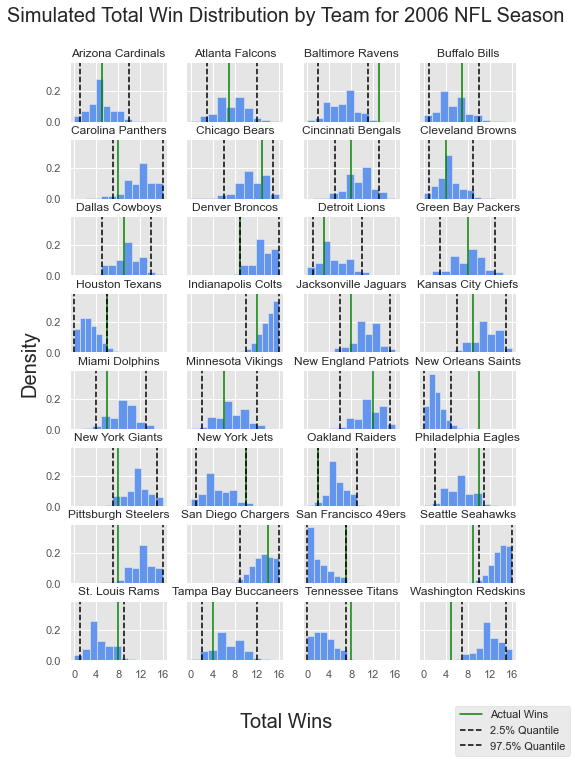

In [184]:
# Create four polar axes and access them through the returned array
fig, ax = plt.subplots(8,4,  sharex=True, sharey=True)

for teamidx, team in enumerate(teams):
    # Calculate row and column access 
    row = math.floor(teamidx / 4)
    col = teamidx - row*4
    
    # Get appropriate dataframe for a given team
    dfTeam = pd.DataFrame(np.array(tables)[:,teamidx,:],  columns = ["team",
                                                                       "totalWins",
                                                                       "totalLosses",
                                                                       "homeWins",
                                                                       "homeLosses",
                                                                       "awayWins",
                                                                       "awayLosses",
                                                                       "leagueRank",
                                                                       "division", 
                                                                       "divisionRank"])
    
    # Plot histogram, set title
    ax[row, col].hist(dfTeam["totalWins"], bins=10, color = "cornflowerblue", density = True)
    ax[row, col].set_title(team, fontsize=12)
    
    # Plot lines at Actual win total, and 95% Prediction Interval
    ax[row, col].axvline(x=summary_loaded.loc[team, "Actual_Wins"], color = "green", label = "Actual Wins")
    ax[row, col].axvline(x=np.percentile(dfTeam["totalWins"],2.5, interpolation='nearest'), color = "black",ls = "--", label = "2.5% Quantile")
    ax[row, col].axvline(x=np.percentile(dfTeam["totalWins"],97.5, interpolation='nearest'), color = "black",ls="--", label = "97.5% Quantile")
    ax[row, col].set_xticks([0,4,8,12,16])

    
# Plot common Legend
lines, labels = fig.axes[-1].get_legend_handles_labels()
fig.legend(lines, labels, loc = 'lower right')

# Label common X and Y axes
fig.text(0.5, 0.04, 'Total Wins', ha='center', fontsize=20)
fig.text(0.04, 0.5, 'Density', va='center', rotation='vertical', fontsize=20)

# Add Super title
fig.suptitle('Simulated Total Win Distribution by Team for 2006 NFL Season', fontsize=20,  y=0.95)

# Adjust space between plots
plt.subplots_adjust(hspace = 0.3)

# Set size of the figure 
fig.set_size_inches(8, 11)

# Save the figure
fig.savefig('data/2006sims.png', dpi=100)